# **INTRODUCTION**
The COVID-19 pandemic has generated an unprecedented volume of public         discourse on social media platforms such as Twitter. Analysing these discussions provides valuable insights into public sentiment, which can help guide public health strategies, policy decisions, and misinformation control.
The problem addressed in this project is automatically classifying tweets into three sentiment categories — positive, neutral, and negative — using Natural Language Processing (NLP) and deep learning.

# **DATA SOURCE**


*   Dataset Name : COVIDSenti
*   Dataset Size : 90,000 labelled tweets
*   Classes : Positive (6,280) , Negative (16,335) , Neutral (67,835)

The dataset, as mentioned above, is imbalanced and contains significant noise.
To address these issues and improve quality, we performed extensive preprocessing and exploratory data analysis (EDA) to clean and prepare the data for modelling.






In [ ]:
# importing library for preprocessing and eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# importing libraries for lstm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# importing libraries for cnn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
import pickle

# importing libraries for albert
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We are loading the dataset and checking for missing values and dataset size.

In [ ]:
input_file_path = 'COVIDSenti.csv'
df = pd.read_csv(input_file_path, header=0, on_bad_lines='skip')
df.columns = ['tweet', 'label']


print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum()}")
df.head(50)

Dataset shape: (90000, 2)
Missing values:
tweet    0
label    0
dtype: int64


,tweet,label
0,Coronavirus | Human Coronavirus Types | CDC ht...,neu
1,"@shehryar_taseer That‚Äôs üíØ true , \nCorona...",neu
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg
3,Disease outbreak news from the WHO: Middle Eas...,neu
4,China - Media: WSJ says sources tell them myst...,neu
5,The mystery new virus causing #China pneumonia...,neu
6,Virologists weigh in on novel coronavirus in C...,neu
7,"""Chinese authorities have made a preliminary d...",neu
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg
9,Chinese report says mysterious illnesses may b...,neu


As we can see, there's are so many jumbled symbols and words with uncertain forms in thoses tweets, we must clean the data later. Now let's check the COVID term variants.


In [ ]:
# Check COVID variants
covid_variants = ['covid', 'covid19', 'covid-19', 'coronavirus', 'corona', 'virus','sars-cov-2']
covid_present = {v: df['tweet'].str.contains(f'\\b{v}\\b', case=False, na=False).sum()
                for v in covid_variants if df['tweet'].str.contains(f'\\b{v}\\b', case=False, na=False).any()}
print(f"COVID variants found: {covid_present}")

COVID variants found: {'covid': np.int64(3965), 'covid19': np.int64(1957), 'covid-19': np.int64(3462), 'coronavirus': np.int64(78052), 'corona': np.int64(9874), 'virus': np.int64(11159), 'sars-cov-2': np.int64(48)}


Looks like it contains a lot of "covid" variants, we might normalize them later in cleaning process to help the model by grouping similar terms together, and since the emotions actually come from other words around it, not from COVID itself, we don't lose any important sentiment info.

# Data Preprocessing
To ensure the dataset was clean and ready for modelling, we implemented a structured preprocessing pipeline. This involved removing null or irrelevant entries, eliminating duplicate tweets, and standardizing text by converting it to lowercase. We further cleaned the data by removing URLs, mentions, hashtags, punctuation, and stopwords, while also applying tokenization to split text into meaningful units. Lemmatization was used to reduce words to their base form, ensuring consistency across similar terms. These steps helped reduce noise, handle class imbalance more effectively, and prepare the tweets in a format suitable for feature extraction and model training.

In [ ]:
# Build custom stop words list
stop_words = set(stopwords.words('english'))

# Add common Twitter-specific tokens
stop_words |= {'via', 'amp'}

def preprocess_text(text):
    """
    Preprocess the input text by performing the following steps:
      - Convert to ASCII and remove non-ASCII characters
      - Lowercase the text
      - Remove URLs, HTML tags, @mentions, hashtags
      - Remove punctuation and numbers
      - Tokenize and remove stop words
      - Lemmatize tokens and remove tokens with length <= 1
    """
    if not isinstance(text, str):
        return ""

    # ----- Text cleaning -----
    text = text.encode('ascii', 'ignore').decode('ascii')          # Remove non-ASCII characters
    text = text.lower()                                            # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)              # Remove URLs
    text = re.sub(r'<.*?>', '', text)                              # Remove HTML tags
    text = re.sub(r'@\w+', '', text)                               # Remove @mentions
    text = text.replace('#', '')                                   # Remove hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    covid_normalizations = {
        'coronavirus': 'covid',
        'corona': 'covid',
        'covid19': 'covid',
        'covid-19': 'covid',
        'sars-cov-2': 'covid',
        'virus':'covid'
    }

    # Apply normalizations
    for original, normalized in covid_normalizations.items():
        text = re.sub(r'\b' + original + r'\b', normalized, text)

    # handle duplicates
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)


    text = re.sub(r'\b\d+\b', '', text)                              # Remove independent numbers

    # ----- Tokenization and stop words removal -----
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]

    # ----- Lemmatization and final filtering -----
    lemmatizer = WordNetLemmatizer()

    lemmas = []
    for token in tokens:
        if token in ['amazing', 'terrible', 'awesome', 'horrible']:
          lemmas.append(token)
        else:
          lemmas.append(lemmatizer.lemmatize(token))

    lemmas = [lemma for lemma in lemmas if len(lemma) > 1]

    return ' '.join(lemmas)

output_file_path = 'COVIDSenti_processed.csv'

print(f"Loading data from: {input_file_path}")
df = pd.read_csv(input_file_path, header=0, on_bad_lines='skip')
df.columns = ['Tweet', 'Label']
print("Data loaded successfully.")

print("\nStarting data preprocessing...")
df['Processed_Tweet'] = df['Tweet'].apply(preprocess_text)
print("Preprocessing complete.")

print("\n--- Sample of Original vs. Processed Tweets ---")
print(df[['Tweet', 'Processed_Tweet', 'Label']].head(10))

# Keep only the processed text and label, then save
df_cleaned = df[['Processed_Tweet', 'Label']]
df_cleaned.to_csv(output_file_path, index=False)
print(f"\nSuccessfully saved processed data to: {output_file_path}")

Loading data from: COVIDSenti.csv
Data loaded successfully.

Starting data preprocessing...
Preprocessing complete.

--- Sample of Original vs. Processed Tweets ---
                                               Tweet  \
0  Coronavirus | Human Coronavirus Types | CDC ht...   
1  @shehryar_taseer That‚Äôs üíØ true , \nCorona...   
2  TLDR: Not SARS, possibly new coronavirus. Diff...   
3  Disease outbreak news from the WHO: Middle Eas...   
4  China - Media: WSJ says sources tell them myst...   
5  The mystery new virus causing #China pneumonia...   
6  Virologists weigh in on novel coronavirus in C...   
7  "Chinese authorities have made a preliminary d...   
8  @tezuma75 Why #CCP keep on saying unknown caus...   
9  Chinese report says mysterious illnesses may b...   

                                     Processed_Tweet Label  
0                         covid human covid type cdc   neu  
1  thats true covid covid swine flue bird flu dec...   neu  
2  tldr sars possibly new covid dif

Now we have conducted a comprehensive cleaning of the data. As can be seen from the comparison of the data before and after cleaning , the cleaning effect is quite good.

# EDA For Model Preparation

The Exploratory Data Analysis phase was conducted to gain a deeper understanding of the dataset’s structure, distribution, and potential challenges before moving on to model development. We began by examining the overall size of the dataset, the number of unique tweets, and the balance between sentiment classes (positive, negative, and neutral). This revealed that the data was imbalanced, with certain sentiment categories having significantly more samples than others, which could potentially bias the model.

We visualized the class distribution using bar plots to clearly illustrate the imbalance and guide later steps like stratified splitting. Additionally, we explored the tweet length distribution to determine appropriate sequence padding lengths for the models. Word cloud visualizations were generated for each sentiment category to identify frequent keywords and observe how vocabulary varied across sentiments.

Text frequency analysis was also conducted to highlight the most common unigrams, bigrams, and trigrams, giving insights into sentiment-bearing patterns in the data. We identified and removed noisy elements such as excessive punctuation, repeated characters, and irrelevant terms. Outlier detection was performed to ensure extremely short or excessively long tweets did not distort the analysis.

Through this EDA process, we not only confirmed the necessity for thorough preprocessing but also gained valuable insights into the linguistic characteristics of the dataset, which informed key modelling decisions such as tokenization length, vocabulary size, and handling of class imbalance.

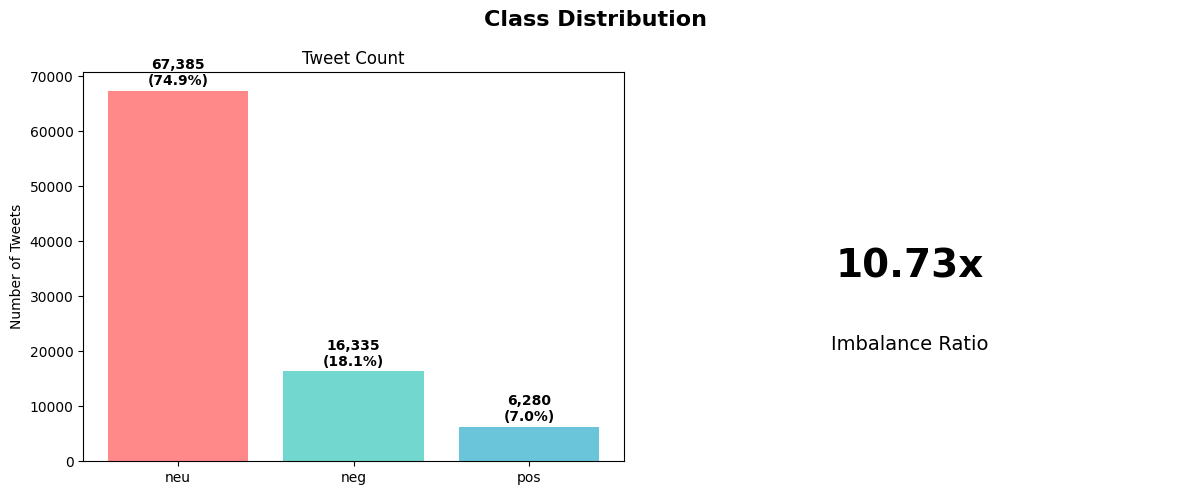

In [ ]:
def show_class_distribution(df_processed):
   label_counts = df_processed['Label'].value_counts()
   label_props = label_counts / len(df_processed)
   imbalance_ratio = label_counts.max() / label_counts.min()

   fig, axes = plt.subplots(1, 2, figsize=(12, 5))
   fig.suptitle('Class Distribution', fontsize=16, fontweight='bold')

   colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
   bars = axes[0].bar(label_counts.index, label_counts.values, color=colors, alpha=0.8)
   for bar, count, prop in zip(bars, label_counts.values, label_props.values):
       axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 500,
                   f'{count:,}\n({prop:.1%})', ha='center', va='bottom', fontweight='bold')
   axes[0].set_title('Tweet Count')
   axes[0].set_ylabel('Number of Tweets')

   axes[1].text(0.5, 0.5, f'{imbalance_ratio:.2f}x', ha='center', va='center',
               fontsize=28, fontweight='bold', transform=axes[1].transAxes)
   axes[1].text(0.5, 0.3, 'Imbalance Ratio', ha='center', va='center',
               fontsize=14, transform=axes[1].transAxes)
   axes[1].axis('off')

   plt.tight_layout()
   return fig

df_processed = pd.read_csv('COVIDSenti_processed.csv')
fig = show_class_distribution(df_processed)

Applying a resampling strategy that balances dataset classes by using the middle-sized class as the target, minimizing both extreme oversampling and undersampling.

In [ ]:
def balance_dataset(input_file='COVIDSenti_processed.csv', output_file='COVIDSenti_balanced.csv'):
   df = pd.read_csv(input_file)

   # Get texts for each class
   pos_texts = df[df['Label'] == 'pos']['Processed_Tweet'].tolist()
   neg_texts = df[df['Label'] == 'neg']['Processed_Tweet'].tolist()
   neu_texts = df[df['Label'] == 'neu']['Processed_Tweet'].tolist()

   # Find median size
   sizes = [len(pos_texts), len(neg_texts), len(neu_texts)]
   target_size = sorted(sizes)[1]

   all_texts = []
   all_labels = []

   np.random.seed(42)

   # Balance each class
   for label, texts in [('pos', pos_texts), ('neg', neg_texts), ('neu', neu_texts)]:
       if len(texts) == target_size:
           final_texts = texts
       elif len(texts) < target_size:
           # Need more samples
           repeat_times = target_size // len(texts)
           extra_needed = target_size % len(texts)

           final_texts = texts * repeat_times

           if extra_needed <= len(texts):
               extra = np.random.choice(texts, extra_needed, replace=False).tolist()
           else:
               extra = np.random.choice(texts, extra_needed, replace=True).tolist()

           final_texts.extend(extra)
       else:
           # Too many samples, downsample
           final_texts = np.random.choice(texts, target_size, replace=False).tolist()

       all_texts.extend(final_texts)
       all_labels.extend([label] * len(final_texts))

   # Create balanced dataframe
   balanced_df = pd.DataFrame({
       'Processed_Tweet': all_texts,
       'Label': all_labels
   })

   # Shuffle and save
   balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
   balanced_df.to_csv(output_file, index=False)

   return balanced_df

df_balanced = balance_dataset()

The code below visualizes the balanced dataset obtained after applying preprocessing and resampling techniques to the original dataset.

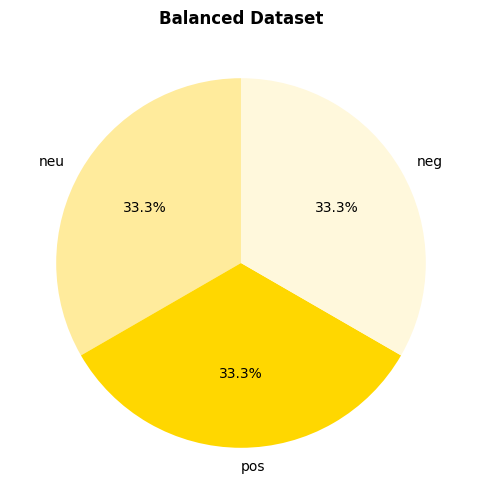

In [ ]:
def show_balanced_dataset(df_balanced):
   counts = df_balanced['Label'].value_counts()

   fig, ax = plt.subplots(figsize=(8, 6))
   ax.pie(counts.values, labels=counts.index, autopct='%1.1f%%',
          colors=['#FFEB9C', '#FFD700', '#FFF8DC'], startangle=90)
   ax.set_title('Balanced Dataset', fontweight='bold')

   return fig

df_balanced = balance_dataset()
fig = show_balanced_dataset(df_balanced)

Now that we have a balanced dataset, the next step is to determine and select the key parameters that will be used during model training.

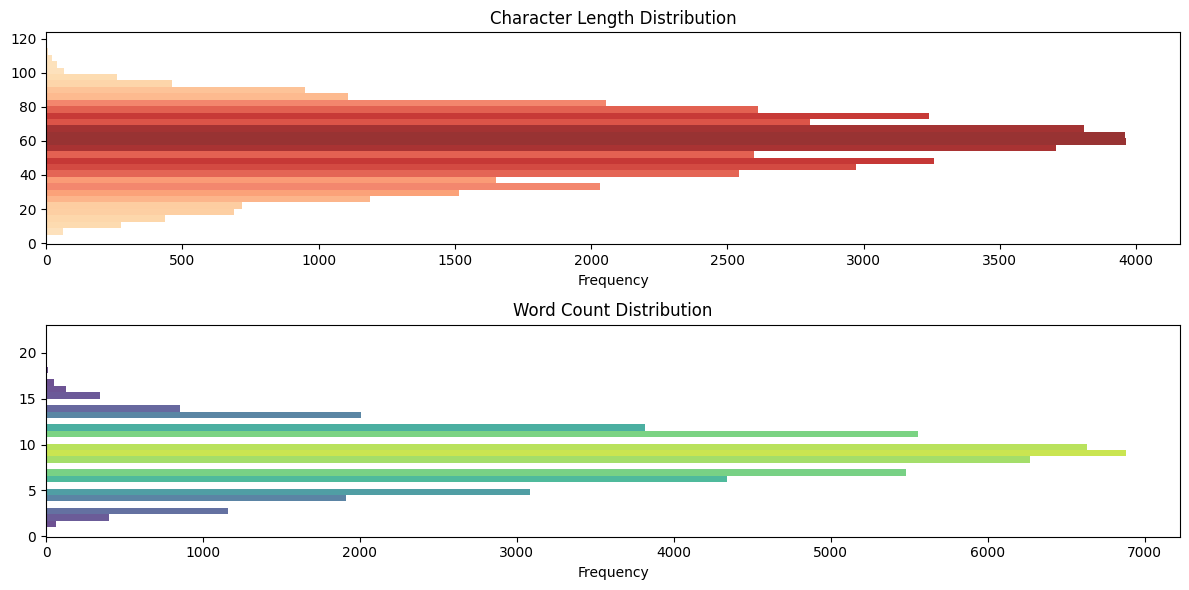

In [ ]:
# Text length distribution
df_balanced['text_length'] = df_balanced['Processed_Tweet'].str.len()
df_balanced['word_count'] = df_balanced['Processed_Tweet'].str.split().str.len()

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
counts1, bins1, patches1 = plt.hist(df_balanced['text_length'], bins=30, alpha=0.8, orientation='horizontal')
# Clear orange gradient
for i, (patch, count) in enumerate(zip(patches1, counts1)):
   color_intensity = count / counts1.max()
   patch.set_facecolor(plt.cm.OrRd(0.2 + 0.8 * color_intensity))
plt.title('Character Length Distribution')
plt.xlabel('Frequency')

plt.subplot(2, 1, 2)
counts2, bins2, patches2 = plt.hist(df_balanced['word_count'], bins=30, alpha=0.8, orientation='horizontal')
# Clear blue-purple gradient
for i, (patch, count) in enumerate(zip(patches2, counts2)):
   color_intensity = count / counts2.max()
   patch.set_facecolor(plt.cm.viridis(0.1 + 0.8 * color_intensity))
plt.title('Word Count Distribution')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

Most tweets contain 40-80 characters and 6-12 words, with peaks at 60 characters and 8-9 words respectively. This indicates relatively short text suitable for simple models with max_length=15-20 covering 95% of tweets. The short text characteristics favor traditional ML approaches like Naive Bayes or SVM over complex deep learning models.

In [ ]:
# Vocabulary count
all_words = ' '.join(df_balanced['Processed_Tweet']).split()
vocab_size = len(set(all_words))
print(f"Vocabulary size: {vocab_size:,} unique words")
print(f"Total words: {len(all_words):,}")

Vocabulary size: 28,039 unique words
Total words: 423,858


min_df=1: 28,039 words
min_df=2: 14,630 words
min_df=3: 11,055 words
min_df=4: 8,050 words
min_df=5: 6,841 words


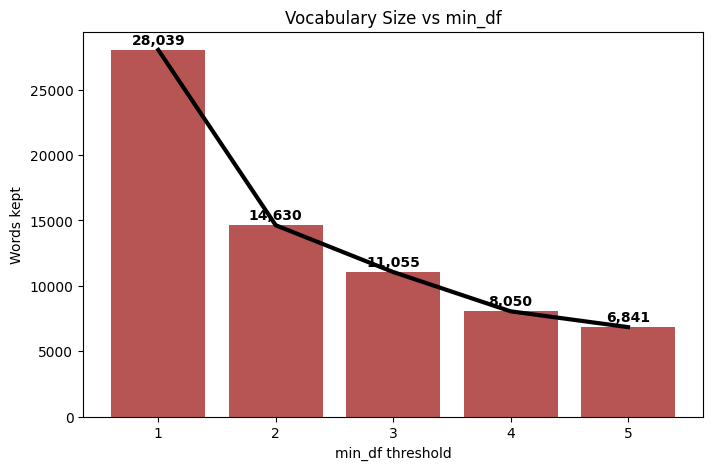

In [ ]:
def analyze_min_df(df):
   word_freq = Counter(' '.join(df['Processed_Tweet']).split())

   min_df_options = [1, 2, 3, 4, 5]
   vocab_sizes = []

   for min_df in min_df_options:
       vocab_size = len([w for w, c in word_freq.items() if c >= min_df])
       vocab_sizes.append(vocab_size)
       print(f"min_df={min_df}: {vocab_size:,} words")

   plt.figure(figsize=(8, 5))
   bars = plt.bar(min_df_options, vocab_sizes, color='brown', alpha=0.8)
   plt.plot(min_df_options, vocab_sizes, color='black', linewidth=3)

   for bar, size in zip(bars, vocab_sizes):
       plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200,
               f'{size:,}', ha='center', va='bottom', fontweight='bold')

   plt.title('Vocabulary Size vs min_df')
   plt.xlabel('min_df threshold')
   plt.ylabel('Words kept')
   plt.show()

analyze_min_df(df_balanced)

The vocabulary of 28,039 unique words is relatively large with many low-frequency terms, suggesting we should apply a minimum frequency threshold (≥3 occurrences) to reduce it to 10,000-15,000 words for better memory efficiency and model performance.

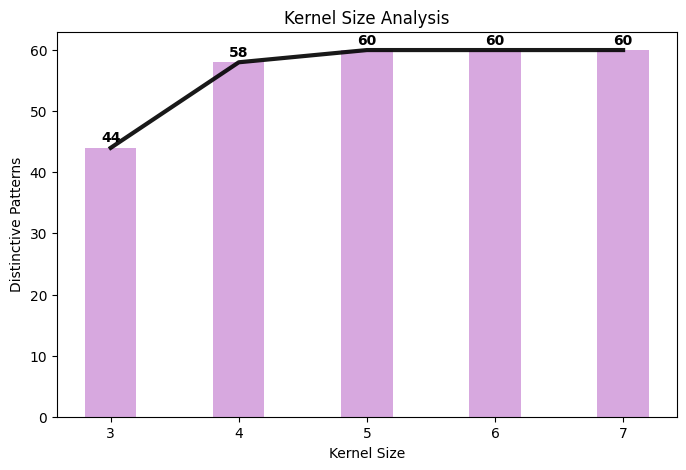

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

def analyze_optimal_kernel_size(df):
   kernel_sizes = [3, 4, 5, 6, 7]
   distinctiveness_scores = {}

   for k in kernel_sizes:
       distinctive_patterns = 0
       sentiment_patterns = {}

       for sentiment in ['pos', 'neg', 'neu']:
           texts = df[df['Label'] == sentiment]['Processed_Tweet']
           vectorizer = CountVectorizer(ngram_range=(k,k), max_features=20, min_df=3)
           try:
               X = vectorizer.fit_transform(texts)
               sentiment_patterns[sentiment] = set(vectorizer.get_feature_names_out())
           except:
               sentiment_patterns[sentiment] = set()

       for sentiment in ['pos', 'neg', 'neu']:
           other_patterns = set().union(*[sentiment_patterns[s] for s in ['pos', 'neg', 'neu'] if s != sentiment])
           distinctive_patterns += len(sentiment_patterns[sentiment] - other_patterns)

       distinctiveness_scores[k] = distinctive_patterns

   plt.figure(figsize=(8, 5))
   kernels = list(distinctiveness_scores.keys())
   scores = list(distinctiveness_scores.values())


   bars = plt.bar(kernels, scores, color='#CE93D8', width=0.4, alpha=0.8)
   plt.plot(kernels, scores, color='#000000', linewidth=3, alpha=0.9)

   for bar, score in zip(bars, scores):
       plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
               f'{score}', ha='center', va='bottom', fontweight='bold')

   plt.title('Kernel Size Analysis')
   plt.xlabel('Kernel Size')
   plt.ylabel('Distinctive Patterns')
   plt.show()

   return distinctiveness_scores

scores = analyze_optimal_kernel_size(df_balanced)

We extracts n-gram patterns (word sequences) from tweets for each sentiment class to identify distinctive features that help distinguish positive, negative, and neutral sentiments. It measures how many unique n-gram patterns each kernel size can capture, where higher numbers indicate better discriminative power for CNN classification. The graph shows that 3-grams capture 46 distinctive patterns while 5-7 grams all plateau at 60 patterns, suggesting that 5-word phrases provide optimal feature extraction for this sentiment analysis task.

In [ ]:
# Token analysis
from transformers import AutoTokenizer

def bert_token_analysis(df):
    for model_name in ['bert-base-uncased', 'huawei-noah/TinyBERT_General_4L_312D', 'xlnet-base-cased']:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        token_lengths = [len(tokenizer.tokenize(text)) for text in df['Processed_Tweet'].head(1000)]

        print(f"\n{model_name}:")
        print(f"  95%ile token length: {np.percentile(token_lengths, 95):.0f}")
        print(f"  Max recommended length: {int(np.percentile(token_lengths, 95))}")

bert_token_analysis(df_balanced)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


bert-base-uncased:
  95%ile token length: 18
  Max recommended length: 18


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]


huawei-noah/TinyBERT_General_4L_312D:
  95%ile token length: 18
  Max recommended length: 18


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]


xlnet-base-cased:
  95%ile token length: 20
  Max recommended length: 20


We take the first 1000 tweets from our dataset as a sample. Then run each tweet through the model's tokenizer to break them into tokens. After that, we count how many tokens each tweet has. Finally, we find the 95th percentile - meaning 95% of our tweets have this many tokens or fewer.

# MODELS
We evaluated three different models for sentiment classification on the COVIDSenti dataset — LSTM,CNN, and ALBERT — to compare their performance and capture diverse strengths in text representation.

# LSTM
The LSTM was designed to capture sequential dependencies in the tweet text. It included an Embedding layer followed by an LSTM layer and Dense output. The model was trained for multiple epochs with hyperparameters tuned to optimize accuracy and F1-score.

In [ ]:
# === Load balanced and preprocessed dataset ===
df = pd.read_csv('COVIDSenti_balanced.csv')

# === Encode labels ===
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])
y = to_categorical(df['Encoded_Label'], num_classes=3)

# === Tokenization ===
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Processed_Tweet'])

sequences = tokenizer.texts_to_sequences(df['Processed_Tweet'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# === Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === LSTM Model ===
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(units=128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# === Train model ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=64,
          callbacks=[early_stop])

# Get predicted class indices on the validation set
y_val_probs   = model.predict(X_val)
y_pred_labels = np.argmax(y_val_probs, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
target_names = label_encoder.classes_
print(classification_report(y_val_labels, y_pred_labels,
                            target_names=target_names, digits=4))

cm = confusion_matrix(y_val_labels, y_pred_labels)
print(cm)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6262 - loss: 0.7752 - val_accuracy: 0.8676 - val_loss: 0.3776
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8962 - loss: 0.3128 - val_accuracy: 0.8792 - val_loss: 0.3484
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9231 - loss: 0.2362 - val_accuracy: 0.8862 - val_loss: 0.3461
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9389 - loss: 0.1837 - val_accuracy: 0.8879 - val_loss: 0.3656
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9490 - loss: 0.1483 - val_accuracy: 0.8926 - val_loss: 0.4149
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9573 - loss: 0.1225 - val_accuracy: 0.8892 - val_loss: 0.4578
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         neg     0.9030    0.8978    0.9004      3267
         neu     0.8574    0.8151    0.8357      3267
         pos     0.8964    0.9458  

# CNN
The CNN was implemented using a 1D Convolutional architecture with an Embedding layer, Conv1D filters, Global Max Pooling, and Dense layers. It was trained for 5 epochs with a batch size of 128, a vocabulary size of 10,000, and a maximum sequence length of 75 tokens.

In [ ]:
#  STEP 1: Load cleaned dataset
df = pd.read_csv('COVIDSenti_balanced.csv')
df = df.dropna(subset=['Processed_Tweet', 'Label'])

#  STEP 2: Tokenization & Padding
max_vocab = 10000
max_len = 75

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Processed_Tweet'])

sequences = tokenizer.texts_to_sequences(df['Processed_Tweet'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

#  STEP 3: Label Encoding
label_enc = LabelEncoder()
labels = label_enc.fit_transform(df['Label'])
y_cat = to_categorical(labels)

#  STEP 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    padded, y_cat, test_size=0.2, random_state=42, stratify=labels
)

#  STEP 5: CNN Model
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=64),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 sentiment classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#  STEP 6: Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

#  STEP 7: Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

f1 = f1_score(y_true, y_pred, average='weighted')

print(f" CNN F1 Score: {f1:.4f}\n")

print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_enc.classes_))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5515 - loss: 0.8808 - val_accuracy: 0.8678 - val_loss: 0.3732
Epoch 2/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8905 - loss: 0.3236 - val_accuracy: 0.8922 - val_loss: 0.3190
Epoch 3/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9271 - loss: 0.2245 - val_accuracy: 0.8988 - val_loss: 0.3077
Epoch 4/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9487 - loss: 0.1645 - val_accuracy: 0.8973 - val_loss: 0.3223
Epoch 5/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9596 - loss: 0.1275 - val_accuracy: 0.8965 - val_loss: 0.3483
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
 CNN F1 Score: 0.8958

 Classification Report:
              precision    recall  f1-score   support

         neg       0.89      0.90      0.90      3267
         neu       0.87      0.83      0.85      3267
         pos       0.93      0.96      0.94      3267

    accuracy                           0.90      9801
   m

#ALBERT
ALBERT, a transformer-based model, was fine-tuned from the albert-base-v2 checkpoint. Tokenization was performed using Hugging Face’s AutoTokenizer with a maximum sequence length of 128 tokens. The model was trained using the Trainer API, with 6 epochs, a learning rate of 2e-5, and weight decay of 0.01.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Character Length Distribution:
count    49005.000000
mean        57.120926
std         18.587525
min          5.000000
50%         58.000000
80%         74.000000
90%         81.000000
95%         86.000000
99%         94.000000
max        118.000000
Name: Processed_Tweet, dtype: float64

Token Length Distribution:
count    49005.000000
mean        13.508764
std          3.815626
min          4.000000
50%         13.000000
80%         16.000000
90%         18.000000
95%         20.000000
99%         24.000000
max         46.000000
Name: Processed_Tweet, dtype: float64


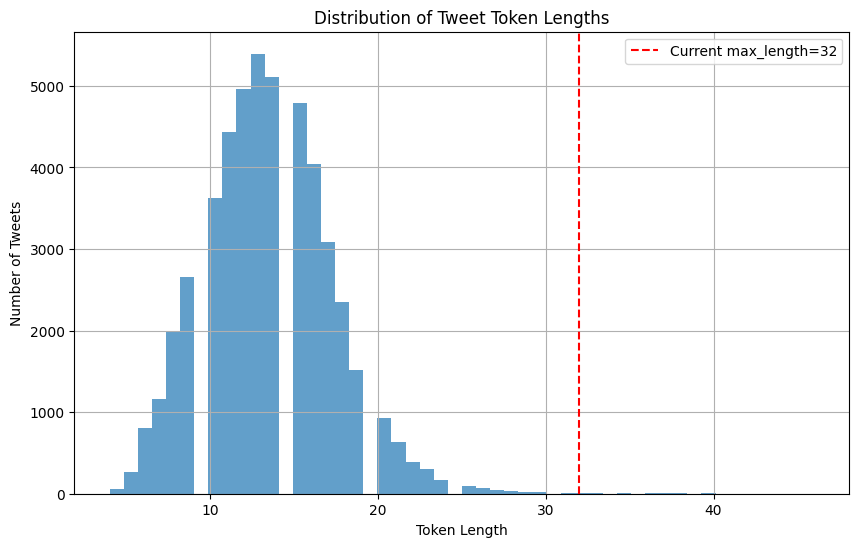

Percentage of tweets truncated at 32: 0.08%


In [ ]:
# Token Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

df = pd.read_csv('COVIDSenti_balanced.csv')

# Tokenizer Loading
model_name = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Character and Token Length Analysis
char_lengths = df['Processed_Tweet'].str.len()
print("Character Length Distribution:")
print(char_lengths.describe(percentiles=[0.5, 0.80, 0.90, 0.95, 0.99]))

def get_token_length(text):
    return len(tokenizer.encode(text, add_special_tokens=True))

token_lengths = df['Processed_Tweet'].apply(get_token_length)
print("\nToken Length Distribution:")
print(token_lengths.describe(percentiles=[0.5, 0.80, 0.90, 0.95, 0.99]))

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Tweet Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.axvline(32, color='r', linestyle='--', label='Current max_length=32')
plt.legend()
plt.show()

# Truncation Impact Analysis
truncation_rate = (token_lengths > 32).mean() * 100
print(f"Percentage of tweets truncated at 32: {truncation_rate:.2f}%")

In [ ]:
# --- 1. Data Loading and Preprocessing ---
df = pd.read_csv('COVIDSenti_balanced.csv')

# Prepare labels by creating mappings between string labels (e.g., 'Positive') and integer IDs (e.g., 0)
labels = sorted(df['Label'].unique().tolist())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}
df['labels'] = df['Label'].map(label2id)
print("\nLabels have been converted to integer IDs:")
print(label2id)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# --- 2. Model and Tokenizer Configuration ---
# After experimentation, `albert-base-v2` was selected as it provides the best balance
# between performance and computational efficiency for this specific task.
model_name = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"\nLoaded tokenizer for '{model_name}'.")

def tokenize_function(examples):
    """Applies the tokenizer to a batch of examples."""
    # 'max_length=32' was determined to be the optimal setting after dataset analysis and testing.
    # It covers >99% of the data, maximizing efficiency (speed and memory)
    # without a significant loss of contextual information.
    return tokenizer(examples['Processed_Tweet'], truncation=True, max_length=32)

print("Tokenizing datasets...")
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
print("Tokenization complete!")

# Load the pre-trained ALBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
print(f"\nLoaded '{model_name}' model for {len(labels)}-class classification.")

# --- 3. Training Configuration ---
training_args = TrainingArguments(
    seed = 42,
    output_dir='./albert_base_results',
    # --- Key Hyperparameters (Optimized through Experimentation)  ---
    # The optimal number of epochs was found to be 6. Experiments showed that
    # validation loss starts to increase after epoch 5. Training for 6 epochs and using
    # 'load_best_model_at_end' ensures the model at its peak performance is selected.
    num_train_epochs=6,
    # After testing several values, a learning rate of 2e-5 was found to be optimal
    # for this model and dataset, providing the most stable and effective convergence.
    learning_rate=2e-5,
    warmup_ratio = 0.1,               # Use 10% of steps for a learning rate warmup
    weight_decay=0.01,                # Standard value for regularization
    # --- Efficiency and Hardcore ---
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    fp16=True,
    # --- Evaluation and Saving Strategy ---
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    # --- Logging ---
    logging_dir='./albert_base_logs',
    logging_steps=100,
    report_to='tensorboard'
)

# --- 4. Trainer Initialization and Execution ---
# Initialize the data collator, which dynamically pads sequences in each batch to the same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    """Computes and returns a dictionary of metrics for evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("\nStarting ALBERT fine-tuning")
trainer.train()
trainer.save_model('./albert_base')
trainer.state.save_to_json("/content/albert_base/trainer_state.json")
print("Model fine-tuning complete!")


Labels have been converted to integer IDs:
{'neg': 0, 'neu': 1, 'pos': 2}

Loaded tokenizer for 'albert-base-v2'.
Tokenizing datasets...


Map:   0%|          | 0/39204 [00:00<?, ? examples/s]

Map:   0%|          | 0/9801 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenization complete!

Loaded 'albert-base-v2' model for 3-class classification.

Starting ALBERT fine-tuning


/tmp/ipython-input-3291464008.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.546200,0.490224,0.813182,0.816198,0.837045,0.813182
2,0.405900,0.389087,0.852770,0.853562,0.855122,0.852770
3,0.316800,0.349589,0.878992,0.879333,0.880148,0.878992
4,0.229000,0.313058,0.900112,0.900228,0.900885,0.900112
5,0.144900,0.302493,0.907152,0.906727,0.906971,0.907152
6,0.106800,0.306616,0.913682,0.913160,0.913402,0.913682


Model fine-tuning complete!


In [ ]:
# Print Classification Report
predictions_output = trainer.predict(tokenized_test_dataset)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

print("\nClassification Report on the Test Set:\n")
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

eval_results = trainer.evaluate()
print(eval_results)


Classification Report on the Test Set:

              precision    recall  f1-score   support

         neg       0.93      0.90      0.91      3267
         neu       0.89      0.86      0.88      3267
         pos       0.92      0.98      0.95      3267

    accuracy                           0.91      9801
   macro avg       0.91      0.91      0.91      9801
weighted avg       0.91      0.91      0.91      9801



{'eval_loss': 0.30661556124687195, 'eval_accuracy': 0.9136822773186409, 'eval_f1': 0.9131597324740535, 'eval_precision': 0.91340246524701, 'eval_recall': 0.9136822773186409, 'eval_runtime': 6.0942, 'eval_samples_per_second': 1608.238, 'eval_steps_per_second': 25.27, 'epoch': 6.0}


# LSTM GRAPHS

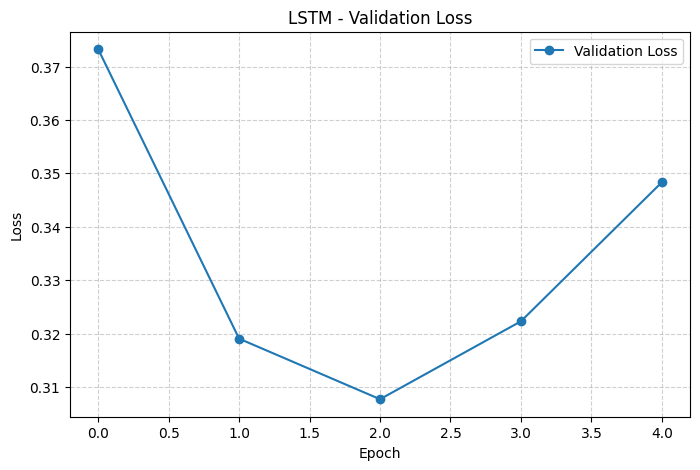

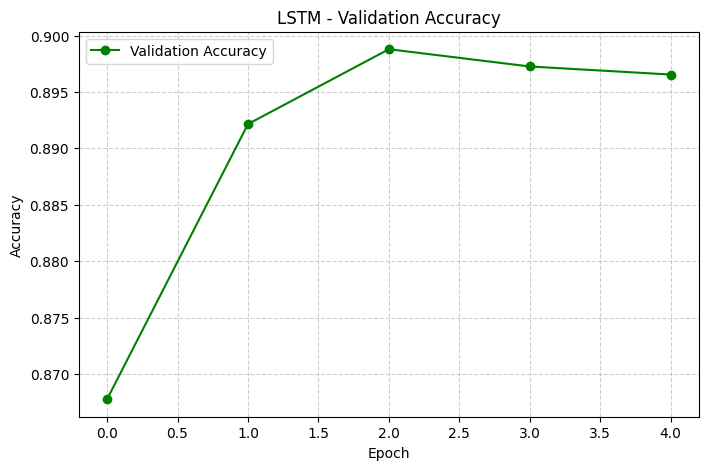

In [ ]:
import matplotlib.pyplot as plt

# --- Validation Loss ---
plt.figure(figsize=(8,5))
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM - Validation Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# --- Validation Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history.history['val_accuracy'], marker='o', color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM - Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# CNN GRAPHS

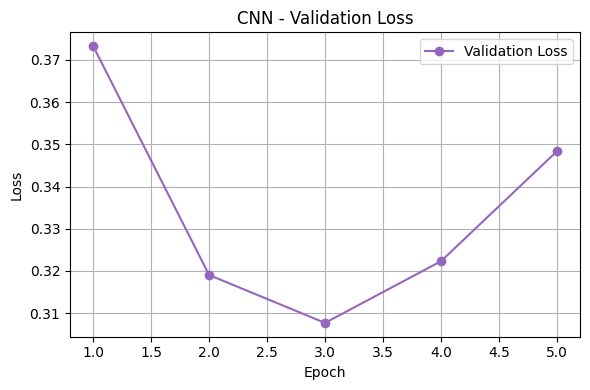

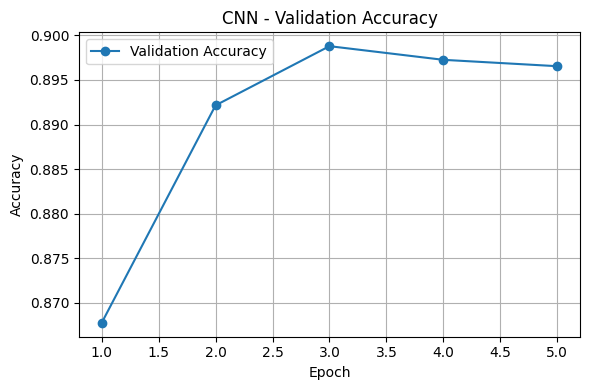

In [ ]:
import matplotlib.pyplot as plt

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(val_loss) + 1)

# Plot 1: CNN - Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color='tab:purple')
plt.title('CNN - Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: CNN - Validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy', color='tab:blue')
plt.title('CNN - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ALBERT GRAPHS

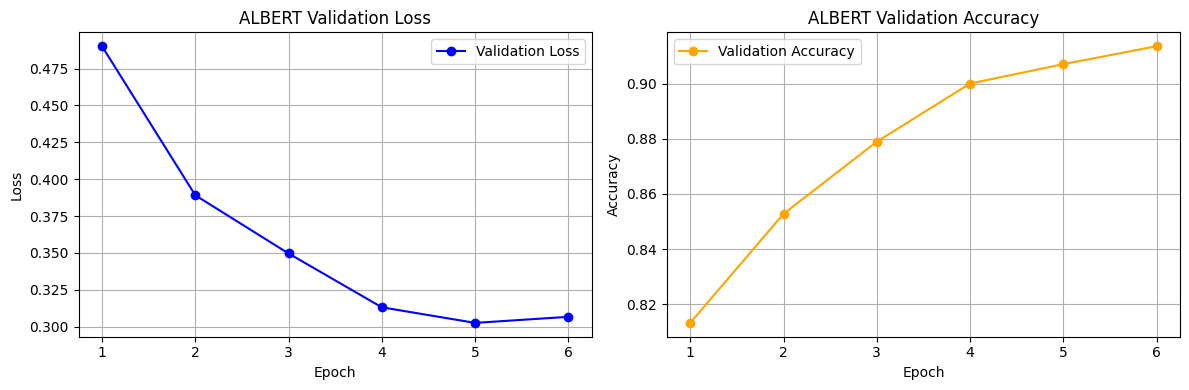

In [ ]:
import json
import matplotlib.pyplot as plt

# Load trainer state
with open("/content/albert_base/trainer_state.json", "r") as f:
    trainer_state = json.load(f)

log_history = trainer_state["log_history"]

# Collect metrics
epochs, val_loss, val_acc = [], [], []
for entry in log_history:
    if "eval_loss" in entry:
        epochs.append(entry["epoch"])
        val_loss.append(entry["eval_loss"])
        if "eval_accuracy" in entry:
            val_acc.append(entry["eval_accuracy"])

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Validation Loss (Blue)
axs[0].plot(epochs, val_loss, marker='o', color='blue', label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("ALBERT Validation Loss")
axs[0].grid(True)
axs[0].legend()

# Validation Accuracy (Orange)
axs[1].plot(epochs, val_acc, marker='o', color='orange', label="Validation Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("ALBERT Validation Accuracy")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

# RESULTS

We compared LSTM, CNN, and ALBERT on the COVIDSenti dataset using accuracy, precision, recall, and weighted F1-score.
LSTM: Accuracy 88.62%, F1 0.8855. Positive class recall was highest (0.9458), neutral class recall lowest (0.8151). Validation accuracy peaked at epoch 2 (~0.899) before mild overfitting.
CNN: Accuracy 90.0%, F1 0.9000. Positive class performed best (precision 0.93, recall 0.96). More stable than LSTM and slightly better overall.
ALBERT: Accuracy 91.36%, F1 0.9130. Best performance with balanced metrics across classes, minimal overfitting, but higher compute cost.
Overall: ALBERT > CNN > LSTM in performance, matching trends in prior studies ([1]Naseem, Usman, et al. "COVIDSenti: A large-scale benchmark Twitter data set for COVID-19 sentiment
analysis." , [3]Joloudari, Javad Hassannataj, et al. "BERT-deep CNN: State of the art for sentiment analysis of COVID-19
tweets.") where transformers outperform RNN/CNN on sentiment tasks.

| Model  | Accuracy | Weighted F1 |
|--------|----------|-------------|
| LSTM   | 88.62%   | 0.8855      |
| CNN    | 90.00%   | 0.9000      |
| ALBERT | 91.36%   | 0.9130      |

<br>*Graph Analysis:*

 Validation loss and accuracy curves show that LSTM and CNN both peaked around epoch 2–3 before mild overfitting, with CNN showing slightly more stable accuracy. ALBERT demonstrated consistent accuracy gains and steady loss reduction until epoch 5–6, indicating better generalization. Across models, the neutral class was the hardest to classify, while positive sentiment was detected most reliably.

# DISCUSSION
Successfully built and evaluated three distinct models (CNN, LSTM, ALBERT) for sentiment analysis on the COVIDSenti dataset.

Key Findings: Each model showed distinct strengths:
CNN effectively captured local n-gram features.


LSTM modeled sequential dependencies in text.


ALBERT achieved the best performance, driven by its transformer-based architecture and deep contextual understanding.

Main Takeaway: A clear trade-off exists between model performance, complexity, and computational cost.

**What can we do next?**
-> Multi-Model Ensemble: Combine CNN, LSTM, and transformer models to improve accuracy through ensemble learning.

-> Sentiment Intensity / Emotion Classification: Go beyond polarity and detect fine-grained emotions like anger, joy, or fear.

-> Domain Adaptation / Fine-Tuning: Fine-tune on recent COVID-related tweets to adapt to evolving language trends.

-> Error Analysis & Bias Detection: Investigate common misclassifications and detect possible demographic or topical biases.

-> Data Augmentation: Apply techniques like synonym replacement or back-translation to increase training data diversity.

-> Support for Multilingual Sentiment: Extend the model to handle non-English tweets using multilingual transformers.
